In [ ]:
from google.colab import drive
drive.mount("/content/drive")

path_data = '/content/drive/MyDrive/Colab/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow_hub
!pip install tensorflow_text
!pip install -U gensim
!pip install pyLDAvis

# Projet NLP: Suggestions de Tags


Après avoir procéder à la préparation du jeu de données dans le notebook précédent, nous allons maintenant modéliser le système de suggestion des tags. Dans ce notebook, on appliquera des modèles d'apprentissages supervisés suivant les deux approches Machine et Deep Learning.


Dans un premier temps, on applique la classification non-supervisée type *Topic Modelling* (approche Machine Learnnig) à l'aide l'algorithme LDA *(Latent Dirichlet Allocation)* de la bibliothèque Python `gensim` sur l'ensemble du jeu d'entraînement. Cette technique de classification permet, en NLP, d'expliquer un document comme une distribution de probabilités de *topics*, ces derniers donnés par une distribution de probabilités de mots-clés (*keywords*). Chaque topic est donc déterminé par les keywords qu'il contient. Le nombre de topics doit être fixé à l'avance, l'apprentissage LDA permet alors d'ajuster la distribution des topics parmi les documents et la distribution des keywords parmi les topics. Une fois la classification optimale des documents obtenue, on utilise une fonction score customisée pour construire une méthode de suggestion de tags.

Dans un second temps, on s'intéressera aux architectures de réseaux de neuronnes (Deep Learning) également très utilisé pour le NLP. On présente ici trois modèles d'apprentissage supervisé: Dans le premier modèle, on va créer un embedding Word2Vec pour tout les mots du corpus d'entrainement à l'aide de `gensim`. Le modèle d'apprentissage sera construit à l'aide de la bibliothèque `Keras`. Pour construire les deux derniers modèles de suggestions, on utilisera deux modèles pré-entraînés comme point de départ (*Transfer Learning*): `BERT` et `Universal Sentence Encoder`. Ces derniers sont optimisés pour permettre d'effectuer des tâches NLP telle que la classification, la réponse aux questions ou l'analyse sémantique.

Pour mesurer la qualité des suggestions (sur le test set), il est à noter que les métriques d'évaluations pour les problèmes de classification multi-label diffèrent légèrement des problèmes de classifications classiques. En effet, les prédictions peuvent être partiellement correcte ou partiellement incorrecte, ce qui ne peut pas se produire pour la classification binaire ou multi-classe. On interpretera les résultats pour chaque modèle via la *précision* et le *rappel*. En particulier, on va suivre les meilleurs prédictions via le *f1-score* qui représente la moyenne harmonique de la précision et du rappel.

  
# <font color="#00afe6">Sommaire</font>
1. [Préparation du jeu de données.](#section_1)                       
2. [Train / val / test split.](#section_2)     
3. [Suggestion supervisée avec LDA.](#section_3)     
    3.1 [Recherche du nombre de topics optimal.](#section_3_1)            
    3.2 [Fonction "score" pour le système de suggestion.](#section_3_2)            
    3.3 [Inférence sur le test set.](#section_3_3)            
4. [Suggestion avec modèle Word2Vec.](#section_4)             
5. [Modélisation via Transfer Learning.](#section_5)                           
    5.1 [Suggestion avec le modèle BERT.](#section_5_1)                   
    5.2 [Suggestion avec le modèle USE.](#section_5_2)                     

In [ ]:
# Importation des librairies python

import sys, time

import re, numpy as np, pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt


from random import randint
from ast import literal_eval
from tqdm import tqdm
tqdm.pandas()

import gensim

import tensorflow as tf
import tensorflow.keras as keras 

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
# path_data = ''
df = pd.read_csv(path_data + 'df_preclean_lemma.csv', index_col=0)

print("Le dataframe contient {} colonnes et {} lignes."\
      .format(df.shape[1],df.shape[0]))

Le dataframe contient 3 colonnes et 37961 lignes.


# <font color="red" id=section_1> 1. Préparation du jeu de données. </font>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37961 entries, 689677 to 665299
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Best_Tags  37961 non-null  object
 1   Body_pc    37961 non-null  object
 2   Body_lm    37961 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [ ]:
df.sample(1)

,Best_Tags,Body_pc,Body_lm
Id,,,
37371264,['.net'],invalidoperationexception unable to resolve service for type microsoft.aspnetcore. i started to convert my asp.net core project to and faced with problem that now does not resolved. for sake of simplicity i created new asp.net project using visual studio template . than i added constructor for homecontroller which template created for me. and after i start application i receive next error invalidoperationexception unable to resolve service for type microsoft.aspnetcore. while attempting to activate testnewcore.controllers.homecontroller . microsoft.extensions.internal.activatorutilities.getservice iserviceprovider sp type type type requiredby boolean isdefaultparameterrequired in my real application i need to resolve in my own service class for getting access to and to . everething works fine in . so how can it suppose to be in ?,invalidoperationexception unable resolve service microsoft aspnetcore start convert asp net core project face problem resolve sake simplicity create new asp net project visual studio template add constructor homecontroller template create start application receive next invalidoperationexception unable resolve service microsoft aspnetcore attempt activate testnewcore controller homecontroller microsoft extension internal activatorutilitie getservice iserviceprovider requiredby boolean isdefaultparameterrequire real application resolve service class access everethe fine suppose


Le dataframe contient deux colonnes de textes (`Body_lm` et `Body_pc`) qui seront utilisées selon le modèle employé. La colonne `Body_lm` contenant du texte *tokenized* et *lemmatized* sera utilisée pour les modèles LDA et Word2Vec. La colonne `Body_pc` qui contient les textes pré-nettoyés (conserve du "context" par rapport à la variable précédente) sera utilisée pour le transfert learning.

La colonne `Best_Tags` est la colonne cible.

In [ ]:
df['Best_Tags'] = df['Best_Tags'].progress_apply(lambda x: literal_eval(x))

100%|██████████| 37961/37961 [00:00<00:00, 38759.44it/s]


In [ ]:
def split_and_count_tags(df, column, separator):
    list_words = []
    for word in df[column]: #.str.split(separator):
        list_words.extend(word)
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag")\
        .agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    return df_list_words

tags_list_df = split_and_count_tags(df=df, column='Best_Tags', separator=',')
tags_list_df.head()

,tag_count
Tag,
python,4528
java,4294
c#,4088
javascript,4070
android,2776


In [ ]:
nbr_tags = tags_list_df.shape[0]

print("Le jeu de données compte {} tags.".format(nbr_tags))
tags_list = tags_list_df.reset_index()['Tag'].values.tolist()

Le jeu de données compte 35 tags.


Dans le but d'avoir une modélisation rapide et légère, la taille maximale du corps du texte (nombre de *tokens*) sera fixée à 128. Toutes les séquences ayant une longueur supérieure à ce seuil seront tronqués. 

In [ ]:
def troncate_SeqLen(df, columns, maxSeq_len):
    for col in columns:
        for idx, data in tqdm(df[col].apply(lambda x: x.split(" ")).items(), total=len(df)):    
            if (len(data) > maxSeq_len):
                df[col].loc[idx] = " ".join(data[:maxSeq_len]) #.loc[i]
    return df 

def token_distribution(df,col):
    tk = [len(body) for body in df[col].apply(lambda x: x.split(" "))]
    print(f"\n Le corps de texte le plus long contient {max(tk)} tokens. \n")

    plt.figure(figsize=(15,6))
    plt.hist(tk, bins=100)
    plt.title(f"Distribution du nombre de token dans la colonne {col}", fontsize=18)
    plt.xlabel('Nombre de tokens', fontsize=18)
    plt.xticks(fontsize=15)
    plt.ylabel('Nombre de documents', fontsize=18 )
    plt.yticks(fontsize=15)
    plt.show()

In [ ]:
maxSeq_len = 128

df_troncated = troncate_SeqLen(df=df, columns=['Body_lm', 'Body_pc'], maxSeq_len=maxSeq_len)

tags_troncated_list_df = split_and_count_tags(df=df_troncated, column='Best_Tags', separator=',')
nbr_tags               = tags_troncated_list_df.shape[0]

print("Le dataframe compte à présent {} lignes et {} tags uniques".format(df_troncated.shape[0], nbr_tags))

100%|██████████| 37961/37961 [00:03<00:00, 11590.23it/s]


Le dataframe compte à présent 37961 lignes et 35 tags uniques



 Le corps de texte le plus long contient 128 tokens. 



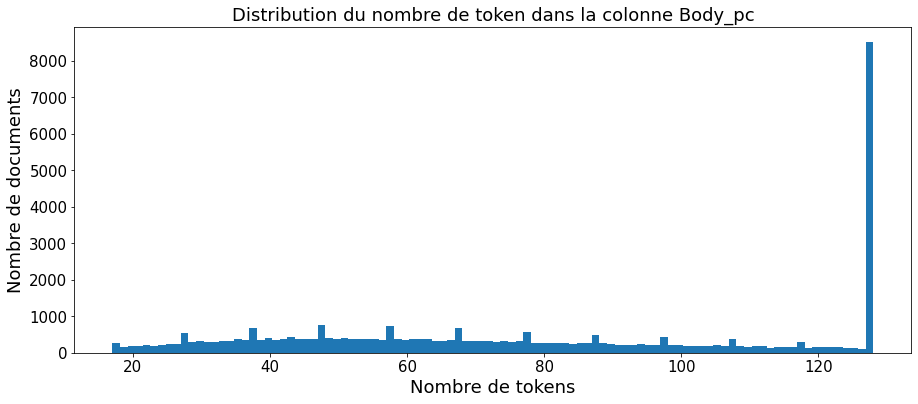

In [ ]:
token_distribution(df_troncated, 'Body_pc')


 Le corps de texte le plus long contient 128 tokens. 



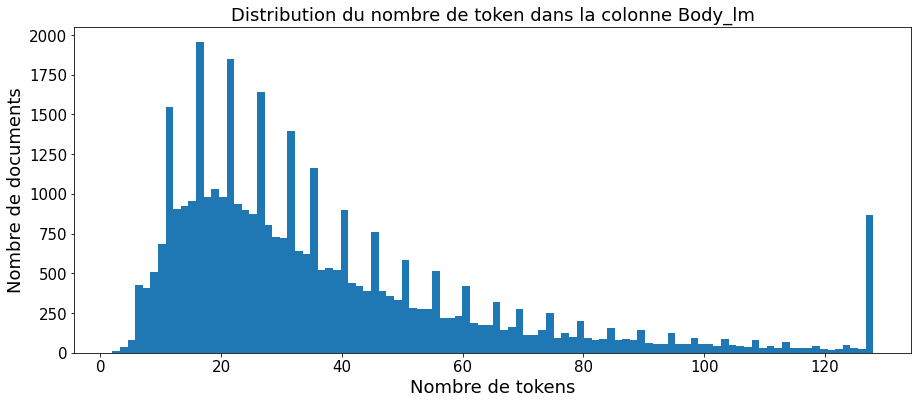

In [ ]:
token_distribution(df_troncated, 'Body_lm')

# <font color="red" id=section_2> 2. Train / test split. </font>

In [ ]:
def split_train_test_data(dataset, train_ratio = 0.9):
    # shuffle dataset
    dataset = dataset.sample(frac=1)

    # train set
    np.random.seed(seed=0)
    train_msk = np.random.rand(len(dataset)) < train_ratio
    train_df = dataset[train_msk]
    print('train_df shape = ', train_df.shape)

    # eval_test set
    test_df  = dataset[~train_msk]
    print('test_df shape = ', test_df.shape)
    
    return train_df, test_df

# Target Labels Binarizer
def binarize_target(train_df, test_df, mlb, column):

    train_label = train_df[column].values.tolist()
    test_label  = test_df[column].values.tolist()

    mlb.fit(train_label)

    train_label_bin = mlb.transform(train_label)
    test_label_bin = mlb.transform(test_label)

    print("Shape of y train: {}".format(train_label_bin.shape))
    print("Shape of y test: {}".format(test_label_bin.shape))
    
    return train_label_bin, test_label_bin, mlb

Tout au long de ce notebook, nous allons utiliser les mêmes jeux d'entraînements et de tests pour entraîner et comparer les différentes modélisations du système de suggestions.

In [ ]:
train_df, test_df = split_train_test_data(df_troncated, train_ratio = 0.96)

##
print()
mlb = MultiLabelBinarizer()
train_label_bin, test_label_bin, mlb = binarize_target(train_df, test_df, mlb, 'Best_Tags')

##
train_label_tags  = mlb.inverse_transform(train_label_bin)
train_label_count = [len(taggs) for taggs in train_label_tags]

test_label_tags   = mlb.inverse_transform(test_label_bin)
test_label_count  = [len(taggs) for taggs in test_label_tags]

train_df shape =  (36465, 3)
test_df shape =  (1496, 3)

Shape of y train: (36465, 35)
Shape of y test: (1496, 35)


In [ ]:
def plot_tag_list_count(label_tags, label_count):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

    pd.DataFrame(label_tags).stack().value_counts().plot(
        kind="bar", 
        ax=axes[0], 
        title='Distribution des tags')
    print('unique tags := ', pd.DataFrame(label_tags).stack().nunique())
  
    pd.DataFrame({'Nombre de tags': label_count}).value_counts().plot(
        kind="bar", 
        ax=axes[1], 
        rot=0, 
        title='Total du nombre de tags par questions')
    plt.show()

unique tags :=  35


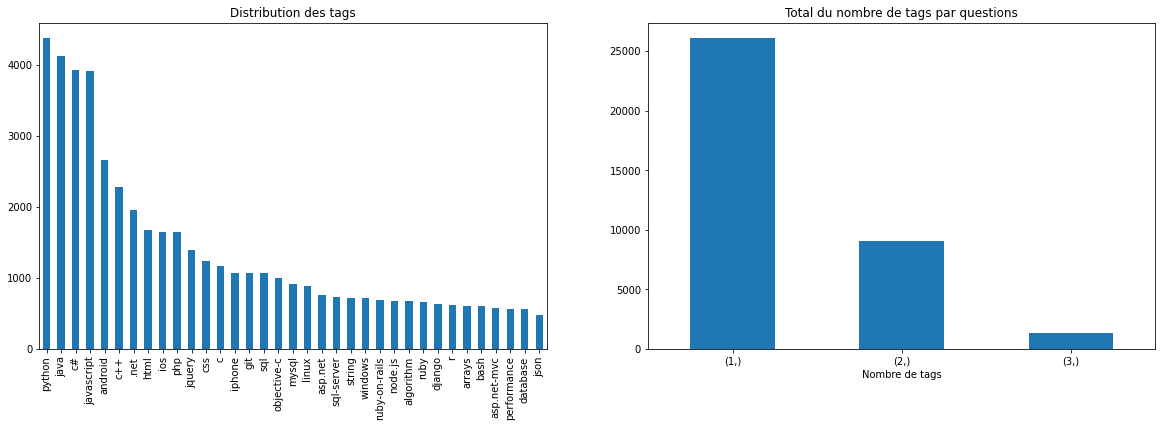

In [ ]:
plot_tag_list_count(train_label_tags, train_label_count)

unique tags :=  35


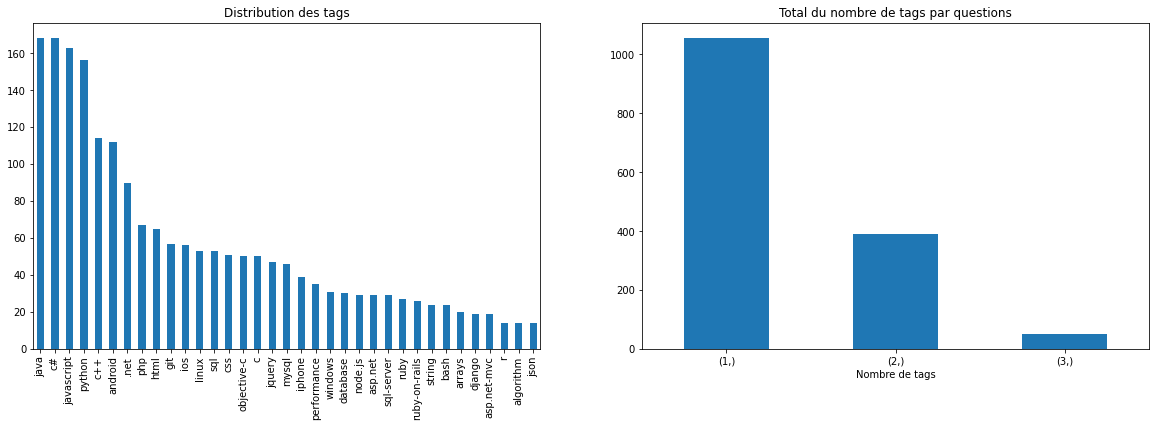

In [ ]:
plot_tag_list_count(test_label_tags, test_label_count)

In [ ]:
# On sauvegarde ces dataframes pour pouvoir comparer les modeles avec les memes train & test sets
train_df.to_csv(path_data + 'train_df_tronc.csv')
test_df.to_csv(path_data + 'test_df_tronc.csv')


 Le corps de texte le plus long contient 128 tokens. 



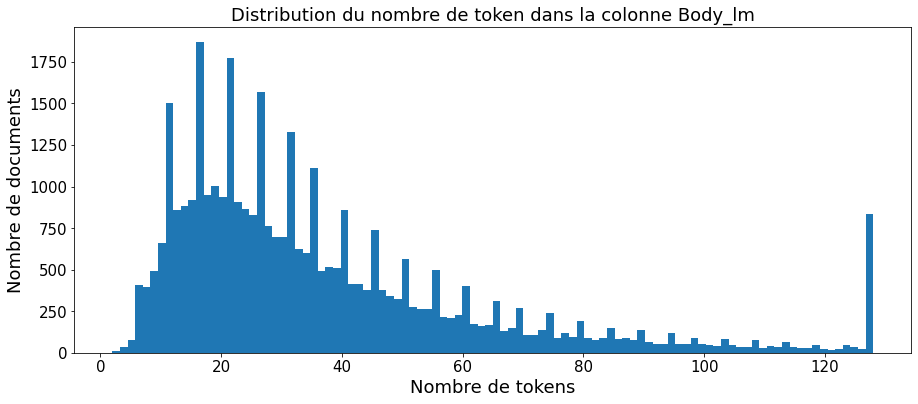

In [ ]:
token_distribution(train_df, 'Body_lm')


 Le corps de texte le plus long contient 128 tokens. 



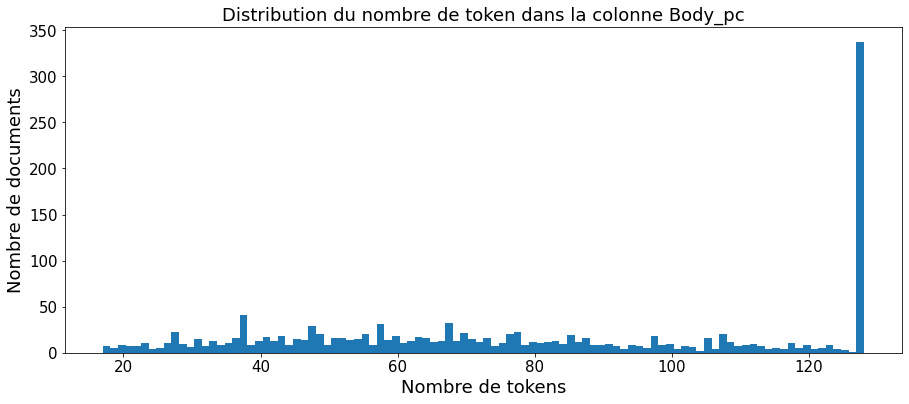

In [ ]:
token_distribution(test_df, 'Body_pc')

In [ ]:
def load_train_test_corpus(train_name, test_name, body, mlb, apply=True, path_data=path_data):

    print('Load '+ train_name)
    train_corpus_df = pd.read_csv(path_data + train_name, index_col=0)
    print('Load '+ test_name)
    test_corpus_df = pd.read_csv(path_data + test_name, index_col=0)
    print()
    
    print('Features:')
    if apply:
      train_feats = train_corpus_df[body].apply(lambda x: x.split(" ")).copy()
      test_feats = test_corpus_df[body].apply(lambda x: x.split(" ")) 
    else:
      train_feats = train_corpus_df[body]
      test_feats = test_corpus_df[body]
    print("Shape of x train: {}".format(train_feats.shape))
    print("Shape of x test: {}".format(test_feats.shape))
    print()
    
    print('Target Binarization:')
    train_corpus_df['Best_Tags'] = train_corpus_df['Best_Tags'].progress_apply(lambda x: literal_eval(x))
    test_corpus_df['Best_Tags']  = test_corpus_df['Best_Tags'].progress_apply(lambda x: literal_eval(x))
    train_label_bin, test_label_bin, mlb = binarize_target(train_corpus_df, test_corpus_df, mlb, 'Best_Tags')
    
    return train_feats, test_feats, train_label_bin, test_label_bin, mlb

In [ ]:
# On utilisera la fonction ci-dessous pour afficher l'historique de l'entraînement des modèles DL

def plot_model_history(model):
  
    acc      = model.history.history[list(model.history.history.keys())[1]]
    val_acc  = model.history.history[list(model.history.history.keys())[3]]
    loss     = model.history.history[list(model.history.history.keys())[0]]
    val_loss = model.history.history[list(model.history.history.keys())[2]]
    epochs   = model.history.epoch

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()  

# <font color="red" id=section_3> 3. Suggestion supervisée avec LDA. </font>

In [ ]:
# Chargement des jeux de données train & test
Body = 'Body_lm'

mlb = MultiLabelBinarizer()

train_feats, test_feats, train_label_bin, test_label_bin, mlb = load_train_test_corpus('train_df_tronc.csv',
                                                                                       'test_df_tronc.csv', 
                                                                                       Body, 
                                                                                       mlb)

Load train_df_tronc.csv
Load test_df_tronc.csv

Features:
Shape of x train: (36465,)
Shape of x test: (1496,)

Target Binarization:


100%|██████████| 1496/1496 [00:00<00:00, 106810.32it/s]

Shape of y train: (36465, 35)
Shape of y test: (1496, 35)


On crée le **Corpus** et le **Dictionnaire** qui sont les deux principales *inputs* pour la LDA permettant la vectorisation du texte. 

In [ ]:
import gensim.corpora as corpora

data_ready = train_feats.copy()

# Create Dictionary
dictionnaire = corpora.Dictionary(data_ready)
dictionnaire.filter_extremes(no_below=2, keep_n=None)

# Create Corpus: Term Document Frequency
corpus = [dictionnaire.doc2bow(text) for text in data_ready]

In [ ]:
# Taille du dictionnaire :
len(dictionnaire)

14029

## <font color="red" id=section_3_1> 3.1 Recherche du nombre de topics optimal. </font>

Pour trouver le nombre optimal de topics, il faut procéder comme avec la méthode du coude. On utilise la *Cohérence* comme métrique.

In [ ]:
from gensim.models import CoherenceModel

# # Hyperparameters that affect sparsity of the topics
# model_alpha = 'asymmetric'

# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,50,5):
    print("Fitting LDA for K = {} topics".format(k))
    start_time = time.time()

    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=dictionnaire,
                                                        num_topics=k,
                                                        random_state=0,
#                                                         alpha=model_alpha,
                                                        passes=10,
                                                        iterations=150,
                                                        per_word_topics=False,
                                                        workers=8)
    # métrique
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=data_ready,
                                         dictionary=dictionnaire,
                                         coherence='c_v')
    
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1 topics
Fitting LDA for K = 6 topics
Fitting LDA for K = 11 topics
Fitting LDA for K = 16 topics
Fitting LDA for K = 21 topics
Fitting LDA for K = 26 topics
Fitting LDA for K = 31 topics
Fitting LDA for K = 36 topics
Fitting LDA for K = 41 topics
Fitting LDA for K = 46 topics


In [ ]:
lda_model.alpha

array([0.02173913, 0.02173913, 0.02173913, 0.02173913, 0.02173913,
       0.02173913, 0.02173913, 0.02173913, 0.02173913, 0.02173913,
       0.02173913, 0.02173913, 0.02173913, 0.02173913, 0.02173913,
       0.02173913, 0.02173913, 0.02173913, 0.02173913, 0.02173913,
       0.02173913, 0.02173913, 0.02173913, 0.02173913, 0.02173913,
       0.02173913, 0.02173913, 0.02173913, 0.02173913, 0.02173913,
       0.02173913, 0.02173913, 0.02173913, 0.02173913, 0.02173913,
       0.02173913, 0.02173913, 0.02173913, 0.02173913, 0.02173913,
       0.02173913, 0.02173913, 0.02173913, 0.02173913, 0.02173913,
       0.02173913], dtype=float32)

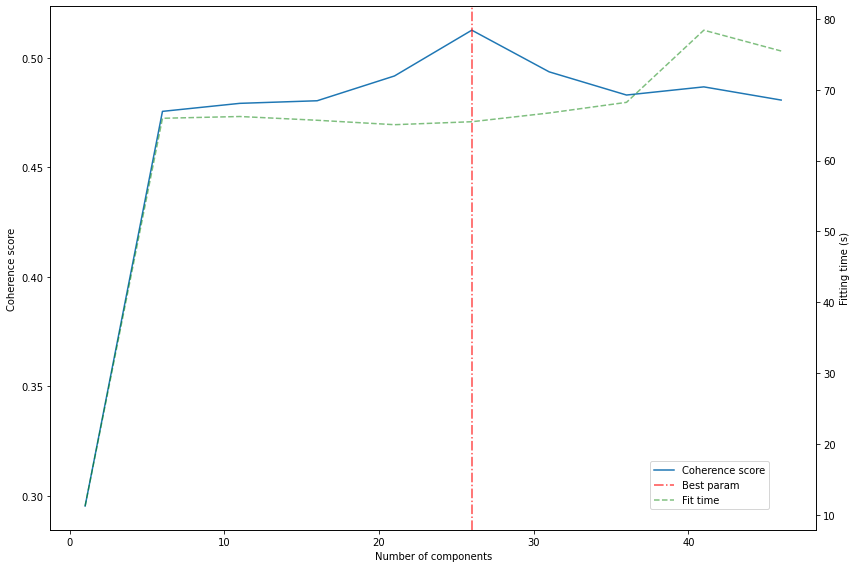

In [ ]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

legend = fig.legend(loc='lower right', bbox_to_anchor=(.9, .1))

fig.tight_layout()
plt.show()
fig.savefig('best_nb_topic.png')

In [ ]:
print(f"Le nombre optimal de topics obtenus est de {best_nb_topics}.")

Le nombre optimal de topics obtenus est de 26.


On va maintenant ré-entrainer le modèle avec ce nombre de topic et obtenir toute les probabilités ayant été calculées. Il est à noter que ce "nombre optimal" peut varier entre 10 et 30, en fonction des hyperparamètres du modèle `gensim` (comme du *random_state* par exemple), cependant l'ordre de grandeur de la Cohérence reste entre 0.45 de 0.5.

In [ ]:
num_topic = best_nb_topics

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                    id2word=dictionnaire,
                                                    num_topics=num_topic,
                                                    random_state=100,
                                                    passes=10,
                                                    iterations=150,
#                                                     alpha=model_alpha,
                                                    workers=8)

In [ ]:
#Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_ready, 
                                     dictionary=dictionnaire, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.532049862552351


Maintenant que le modèle LDA est construit avec le nombre optimal de topics, on peut "visualiser" (projection sur un plan bidimensionnel) les topics ainsi que les keywords associés à l'aide du package de visualition `pyLDAvis`.

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML
pyLDAvis.enable_notebook()

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

gensimvis.prepare(lda_model, corpus, dictionnaire)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.153768  0.108451       1        1  5.735686
8     -0.113014 -0.012863       2        1  5.501199
1      0.115710  0.173280       3        1  5.306804
24    -0.158772 -0.001197       4        1  5.149488
3     -0.095954  0.022261       5        1  4.976943
6     -0.049421 -0.097313       6        1  4.936535
7     -0.011524 -0.129749       7        1  4.666565
15     0.155999 -0.077873       8        1  4.449279
20     0.040125 -0.109408       9        1  4.334163
19    -0.087028  0.064713      10        1  4.260652
12    -0.057580  0.126389      11        1  4.156249
25     0.009564 -0.097645      12        1  4.110019
16     0.096617  0.060746      13        1  3.893888
13    -0.068691  0.045738      14        1  3.818471
17     0.115181  0.125978      15        1  3.687551
23     0.088665 -0.062559      16        1  3.400098
21     0.118698 -0.093344      17        1  3.393556
11     0.151032  0.117451      18        1  3.058755
9     -0.039734 -0.002701      19        1  2.987863
4      0.001407 -0.049836      20        1  2.930597
10    -0.016876 -0.068606      21        1  2.853480
5     -0.045455 -0.037333      22        1  2.813485
22     0.089574  0.055405      23        1  2.631970
2      0.054042 -0.060714      24        1  2.623579
14    -0.083107  0.061580      25        1  2.215107
18    -0.055690 -0.060854      26        1  2.108020, topic_info=         Term         Freq        Total Category  logprob  loglift
168    string  5380.000000  5380.000000  Default  30.0000  30.0000
61      class  7048.000000  7048.000000  Default  29.0000  29.0000
93     object  6039.000000  6039.000000  Default  28.0000  28.0000
288     image  4111.000000  4111.000000  Default  27.0000  27.0000
105     table  4214.000000  4214.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
28        new   144.070710  4860.218560  Topic26  -5.2771   0.3409
381      mean   114.835908  2194.338634  Topic26  -5.5039   0.9093
1023  program   113.875734  2504.655467  Topic26  -5.5123   0.7686
31      point   112.361757  2415.999677  Topic26  -5.5256   0.7913
184   example   108.052041  6884.047638  Topic26  -5.5648  -0.2949

[1986 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
3807     25  0.931413     #
2245      5  0.050436     +
2245      6  0.018913     +
2245     10  0.359353     +
2245     19  0.018913     +
...     ...       ...   ...
1061      3  0.914596  zoom
1061      5  0.017149  zoom
1061     14  0.011432  zoom
1061     23  0.011432  zoom
9213     16  0.960016   zxe

[12034 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 2, 25, 4, 7, 8, 16, 21, 20, 13, 26, 17, 14, 18, 24, 22, 12, 10, 5, 11, 6, 23, 3, 15, 19])

Sur le diagrame ci-dessous est illustré une projection de la classification éffectuée par la LDA. Bien qu'il y ait des chevauchements entre quelques topics, on distingue clairement les topics les uns des autres. Exemple de groupe identifié via LDA:
 1. `git, commit, change, branch, repositery` 
 2. `database, sql, mysql, server, table`
 3. `command, linux, bash`
 4. `javascript, event `
 5. `python, install`
 6. `java, application`
 7. `c++, function,`

Ci-dessous, on montre pour chaque séquences les topics dominants et leurs contributions respectives.

In [ ]:
doc_all_topics = lda_model.get_document_topics(corpus)

print('(Topic Dominant, Document) Contribution')
print(gensim.matutils.corpus2csc(doc_all_topics))

(Topic Dominant, Document) Contribution
  (0, 0)	0.1598774790763855
  (6, 0)	0.2901645302772522
  (9, 0)	0.4909430146217346
  (2, 1)	0.3126259744167328
  (8, 1)	0.21939754486083984
  (25, 1)	0.4502713680267334
  (20, 2)	0.6459499597549438
  (23, 2)	0.29634833335876465
  (1, 3)	0.5477811098098755
  (3, 3)	0.0738920271396637
  (14, 3)	0.0794568583369255
  (17, 3)	0.2663019597530365
  (0, 4)	0.20129366219043732
  (4, 4)	0.08652354776859283
  (12, 4)	0.3871370255947113
  (13, 4)	0.053585369139909744
  (23, 4)	0.1794183999300003
  (25, 4)	0.08103868365287781
  (3, 5)	0.08354642987251282
  (11, 5)	0.6671183109283447
  (17, 5)	0.22079302370548248
  (1, 6)	0.5816323161125183
  (12, 6)	0.11602076143026352
  (17, 6)	0.15949101746082306
  (24, 6)	0.12484341859817505
  :	:
  (9, 36457)	0.3623694181442261
  (19, 36458)	0.10968820005655289
  (21, 36458)	0.8614581823348999
  (1, 36459)	0.5458000898361206
  (17, 36459)	0.2951224446296692
  (20, 36459)	0.13051444292068481
  (1, 36460)	0.203777670860290

On construit la matrice *Documents/Topics* qui représente le plongement (ou *embedding*) des documents dans l'espace des topics.

In [ ]:
# On récupère la matrice des Documents/Topics
mat_sparse = gensim.matutils.corpus2csc(doc_all_topics).T.toarray()

print(mat_sparse.shape)

mat_sparse

(36465, 26)


array([[0.160228  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.31260768, ..., 0.        , 0.        ,
        0.45152968],
       [0.        , 0.        , 0.        , ..., 0.29602239, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

A ce stade, avec cette matrice d'embedding, on peut en principe utiliser un classifieur via les algorithmes Machine Learning tels que la régression logistique ou Random Forest par exemple. Dans ce notebook, on va plutôt une appliquer une méthode customisée qui calculera le score de similarité d'un document test avec l'ensemble du corpus d'entraînement à partir de matrice d'embedding précédente. Les tags associés aux documents ayant le meilleur score seront alors suggérés (inférence) pour le document test.

## <font color="red" id=section_3_2> 3.2 Fonction score pour le système de suggestion.  </font>

Nous allons définir ici la fonction qui permettra d'établir le système de suggestions de tags. Cette dernière calculera un score entre deux séquences basé sur les résultats de la modélisation LDA.

La modélisation LDA nous a donc permis de détermier la distribution de probabilités des topics pour chaque document, et la distribution de probabilité des mots pour chaque topic. Pour chaque document du train set, nous allons uniquement considérer le topic avec la plus grande contribution (il serait certainement plus rigoureux de prendre en compte l'ensemble des topics dominants), et la distribution de probabilité des mots associés à ce topic. 

Dans un premier temps, on détermine le topic dominant du document test (inférence LDA). Ensuite, parmi les documents du train set ayant le même topic dominant (topic avec la plus grande contribution), la fonction score se calculera comme :         

 - Soit $N$ le nombre total de mots dans le document de test, on a alors une somme sur l'ensemble des mots du document test :          
 
    $$\large s = \Pi_{i=1}^{N} p(w_i/t) p(t/d) $$
Où
 - $p(w_i/t)$ est la probabilité du mot $w_i$ pour le topic dominant $t$
 - $p(t/d)$ est la probabilité du topic dominant $t$ pour le document $d$ 
 
 
Le système de suggestion sélectionnera donc parmi les documents "pertinent" du train set ceux avec le score le plus grand (on passera au logarithme dans la pratique). Les tags associés à ces derniers seront donc suggérés au document test.

In [ ]:
def calcul_score(phrase_test, mat_doc_topic=mat_sparse, dictionnaire=dictionnaire, lda_model=lda_model):
    
    # inférence LDA
    test_topic_dist = np.array([tup[1] for tup in lda_model.get_document_topics(
        bow=dictionnaire.doc2bow(phrase_test),
        minimum_probability=0.0)
    ])
    test_dom_topic_idx = np.argsort(test_topic_dist)[-1]
    
    # proba distribution des mots pour le topic dominant
    mots_dist = []
    for word in phrase_test:
        if word in dictionnaire.values():
            all_dist  = lda_model.get_term_topics(word, minimum_probability=0.0)
            if len(all_dist)==lda_model.num_topics:
                term_dist = all_dist[test_dom_topic_idx][1]
                if term_dist > 1e-3:
                    mots_dist.append(term_dist)
                
    # boucle sur les commentaires du train set
    score_comm = []
    for pos, i in enumerate(range(mat_doc_topic.shape[0])):
        
        train_dom_topic_idx = np.argsort(mat_doc_topic[i])[-1]
        
        # uniquement si test & train ont le même topic dominant
        if int(train_dom_topic_idx) == int(test_dom_topic_idx):
            train_test_top = mat_doc_topic[i][train_dom_topic_idx]

            # calcul score en appliquant le logarithme sur la formule précédente
            calcul_score = 0
            for i in range(len(mots_dist)):
                calcul_score += np.log(mots_dist[i]*train_test_top)
            
            # Append resultat pour chaque commentaire
            score_comm.append((pos,calcul_score))
                        
    return score_comm 

#### On montre en premier comment ce système de suggestion fonctionne pour un seul document.

In [ ]:
# Reconstruction du train_df & test_df pour les suggestions et évaluation
train_df = pd.concat(
    [
    pd.Series(train_label_tags, name='Best_Tags', index=train_feats.index), 
    train_feats
    ], 
    axis=1
)
test_df = pd.concat(
    [
    pd.Series(test_label_tags, name='Best_Tags', index=test_feats.index), 
    test_feats
    ], 
    axis=1
)

In [ ]:
# Document test que l'on choisi aléatoirement
iloc = randint(0,test_df.shape[0])
print(iloc)

# print du Body dans le dataframe original
test_df.iloc[iloc].to_frame().T

1185


,Best_Tags,Body_lm
30071886,"(python,)","[current, time, python, break, year, month, day, hour, minute, current, time, python, assign, variable, python]"


In [ ]:
# Calcul
phrase_test = test_feats.iloc[iloc]

score_phr_test = calcul_score(phrase_test)

In [ ]:
score_phr_test_sorted = sorted(score_phr_test, key=lambda x: (x[1]), reverse=True)
score_phr_test_sorted[:10]

[(29457, -53.38766400225185),
 (20595, -53.41468062901734),
 (22720, -53.41468793098035),
 (30875, -53.428942395174786),
 (2377, -53.45784976331833),
 (7990, -53.46461602991183),
 (14135, -53.47130181617308),
 (23702, -53.48657739233955),
 (29356, -53.49491490932297),
 (36335, -53.50367992114721)]

In [ ]:
## Parmi le classement précédent, on recupère les index.
top_pos = [tup[0] for tup in score_phr_test_sorted]

# On recherche dans le train set un "top_N" des suggestions
top_N     = 2
loc_train = train_feats.iloc[top_pos[:top_N]].index

df_sugg = train_df.loc[loc_train] #.to_frame().T
df_sugg

,Best_Tags,Body_lm
Id,,
316238,"(python,)","[python, float, decimal, conversion, python, decimal, support, construct, float, expect, convert, float, string, first, inconvenient, since, standard, string, formatter, float, require, specify, number, decimal, place, significant, place, number, decimal, place, format, give, garbage, decimal, place, significant, digit, decimal, someone, suggest, convert, float, decimal, preserve, value, user, enter, perhaps, limit, number, significant, digit, support]"
447107,"(python, string)","[difference, encode, decode, never, sure, understand, difference, str, unicode, decode, encode, string, byte, certain, character, encoding, give, encode, name, return, unicode, string, convert, unicode, char, string, byte, accord, give, encode, name, understand, anyone, explain, possibly, correct, anything, else, wrong, edit, several, answer, give, info, string, unicode]"


In [ ]:
sugg_tags = [tag for tag_list in df_sugg['Best_Tags'].values.tolist() for tag in tag_list] # 

sugg_tags

['python', 'python', 'string']

Avec la fonction ci-dessous on garde les `unique` de la liste précédente pour obtenir les tags à suggérer.

In [ ]:
def list_unique(list1, tag_max=2):
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
            
    if len(unique_list) <= tag_max:
        final_sugg = unique_list
    else:
        final_sugg = unique_list[:tag_max]
            
    return final_sugg

sugg_unq = list_unique(sugg_tags)
sugg_unq

['python', 'string']

In [ ]:
# Regardons les vrais tags associés au document test (voir plus haut pour "iloc")
test_df.iloc[iloc]

Best_Tags                                                                                                          (python,)
Body_lm      [current, time, python, break, year, month, day, hour, minute, current, time, python, assign, variable, python]
Name: 30071886, dtype: object

## <font color="red" id=section_3_3> 3.3 Inférence sur le test set. </font>

In [ ]:
def suggestion_tags_LDA(test_set, mat_sparse=mat_sparse, train_df=train_df):
    custom_tags = []
    
    for i in tqdm(range(len(test_set)), total=len(test_set)):
        test_sent   = test_set[i]
        scores_test = calcul_score(test_sent,mat_sparse)

        scores_sorted = sorted(scores_test, key=lambda x: (x[1]), reverse=True)
        top_N         = 2
        scores_sorted = scores_sorted[:top_N]
        
        ## Resultat
        top_pos = [tup[0] for tup in scores_sorted]

        # suggestions parmi le train set
        loc_train = train_feats.iloc[top_pos].index
        suggestions_list = train_df['Best_Tags'].loc[loc_train].values.tolist()

        sugg_tags  = [tag for tag_list in suggestions_list for tag in tag_list]
        
        final_sugg = list_unique(sugg_tags)

        custom_tags.append(final_sugg)
        
    return custom_tags

In [ ]:
# Plus maxSeq_len est grand, plus le temps de calcul sera élevé !
lda_label_tags = suggestion_tags_LDA(test_feats.tolist())

100%|██████████| 1496/1496 [04:56<00:00,  5.04it/s]


In [ ]:
lda_label_tags[:10]

[['c#'],
 ['.net', 'c#'],
 ['css', 'html'],
 ['python', 'java'],
 ['python', 'javascript'],
 ['android'],
 ['json', 'python'],
 ['database', 'php'],
 ['c', 'c++'],
 ['python', 'mysql']]

In [ ]:
test_label_tags = mlb.inverse_transform(test_label_bin)

test_label_tags[:10]

[('python',),
 ('html',),
 ('css',),
 ('c', 'c++'),
 ('asp.net', 'c#'),
 ('android',),
 ('java',),
 ('php',),
 ('c', 'python'),
 ('c#',)]

### Évaluation des suggestions 

In [ ]:
lda_label_bin  = mlb.transform(lda_label_tags)

lda_report = pd.DataFrame(classification_report(
    test_label_bin,
    lda_label_bin,
    output_dict=True,
    target_names=mlb.classes_,
    zero_division=0
)).T

In [ ]:
# Moyennisation des métriques utilisées
avg_index = ['samples avg', 'weighted avg','macro avg', 'micro avg' ]

In [ ]:
lda_avg_report = lda_report.loc[avg_index]
lda_avg_report

,precision,recall,f1-score,support
samples avg,0.238302,0.306261,0.255615,1989.0
weighted avg,0.223193,0.296631,0.238107,1989.0
macro avg,0.177509,0.270095,0.197123,1989.0
micro avg,0.222306,0.296631,0.254146,1989.0


In [ ]:
# Classement des 10 meilleures suggestions selon le f1-score
lda_clf_report = lda_report[~lda_report.index.isin(lda_avg_report.index)]
lda_clf_report.sort_values(by='f1-score', ascending=False) #.head(10)

,precision,recall,f1-score,support
git,0.843137,0.811321,0.826923,53.0
c++,0.441860,0.413043,0.426966,92.0
css,0.257669,0.807692,0.390698,52.0
html,0.285714,0.426667,0.342246,75.0
asp.net,0.319149,0.348837,0.333333,43.0
android,0.477273,0.225806,0.306569,93.0
sql,0.250000,0.375000,0.300000,48.0
python,0.221333,0.458564,0.298561,181.0
php,0.322034,0.267606,0.292308,71.0
jquery,0.307692,0.275862,0.290909,58.0


Le déséquilibre de classe présent dans la variable cible affecte grandement les performances globales du modèle. En effet, les classes sous-représentées ne sont pratiquement pas prédites ce qui a pour conséquences de baisser la moyenne d'ensemble des métriques. 

D'autre part, on remarque que le *Recall* est plus élevé que la *Precision* pour la majorité des prédictions. Ce qui veut dire que le modèle suggère beaucoup de labels (*Recall* élevé) mais peu de suggestions sont correctes (*Precision* faible). En effet, avec le système de suggestions établit plus haut, le modèle prédit toujours au moins un tags.

unique tags :=  26


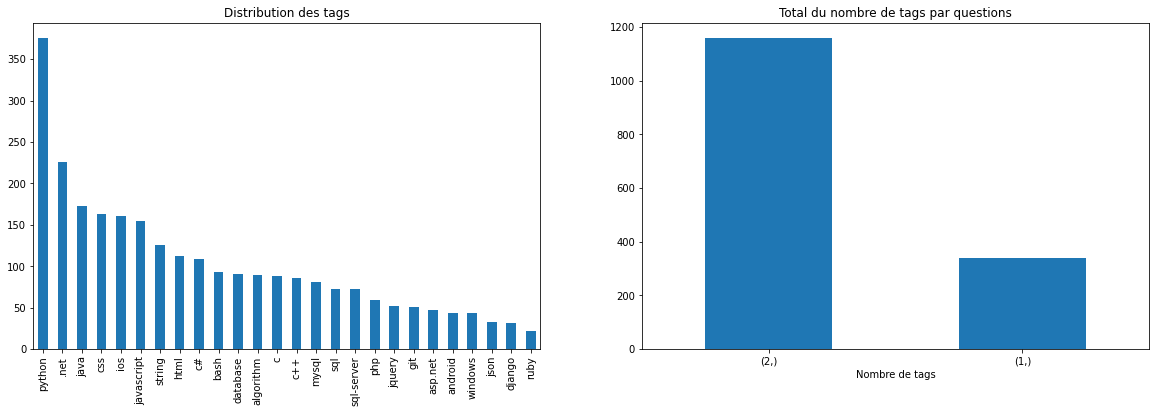

In [ ]:
# Comptage du nombre de tags suggérés dans les prediction LDA
lda_label_count = [len(taggs) for taggs in lda_label_tags]

plot_tag_list_count(lda_label_tags, lda_label_count)

# <font color="red" id=section_4> 4. Suggestion avec modèle Word2Vec </font>

Il existe deux méthodes pour obtenir un embedding en deep learning : soit en apprenant le poids des embeddings pendant l'entraînement soit en chargeant des embeddings pré-entraînés. Dans cette section et la suivante, nous employerons ces deux méthodes. 

En principe, il est possible d'apprendre l'embedding de notre corpus d'entraînement directement grâce à la couche **Embedding** de la bibliothèque `Keras`. Les poids sont initialisés aléatoirement et seront progressivement ajustés par rétropropagation (*on-the-fly*).
Ici, nous allons d'abord générer une matrice d'embedding à l'aide du modèle **Word2Vec** du package `gensim`. Les poids des embeddings ainsi obtenus (pré-entrainés également !) seront ensuite fournit à la couche `Keras` dans le but d'optimiser la performance du modèle. Pour terminer, il y aura une seule couche dense qui sera entraînée pour la classification.

In [ ]:
# Chargement des jeux de données train & test
Body = 'Body_lm'

mlb = MultiLabelBinarizer()

train_feats, test_feats, train_label_bin, test_label_bin, mlb = load_train_test_corpus('train_df_tronc.csv',
                                                                                       'test_df_tronc.csv', 
                                                                                       Body, 
                                                                                       mlb)

Load train_df_tronc.csv
Load test_df_tronc.csv

Features:
Shape of x train: (36465,)
Shape of x test: (1496,)

Target Binarization:


100%|██████████| 1496/1496 [00:00<00:00, 67371.87it/s]


Shape of y train: (36465, 35)
Shape of y test: (1496, 35)


## Création de l'embedding Word2Vec

In [ ]:
# Dimension de l'espace d'embedding
w2v_dim=300 

In [ ]:
# Création et entraînement du modèle d'embedding Word2Vec de gensim
print("Build & train gensim Word2Vec embedding model ...")
w2v_model = gensim.models.Word2Vec(
    min_count=2, 
    window=5,
    vector_size=w2v_dim,
    seed=42,
    workers=8
)
w2v_model.build_vocab(train_feats)
w2v_model.train(
    train_feats, 
    total_examples=w2v_model.corpus_count, 
    epochs=10
)
print("Word2Vec trained")

# Vecteurs d'embedding entraîné sur le corpus
model_vectors  = w2v_model.wv
w2v_vocab      = model_vectors.index_to_key
print("gensim Word2Vec vocabulary size: %i" % len(w2v_vocab))

Build & train gensim Word2Vec embedding model ...
Word2Vec trained
gensim Word2Vec vocabulary size: 17111


## Création de la matrice d'embedding

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_feats) 

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Number of unique words: 32321


In [ ]:
# # word_index = tokenizer.word_index
# print('Keras Tokenizer() vocabulary size :', len(tokenizer.word_index) + 1)

In [ ]:
print("Create Embedding matrix ...")
word_index = tokenizer.word_index
embedding_matrix = np.zeros((num_words, w2v_dim))
    
for word, idx in word_index.items():
    if word in w2v_vocab:
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
print("Embedding matrix shape: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Embedding matrix shape: (32321, 300)


Tokenization des inputs pour l'entraînement et l'inférence.

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_feats) 
train_padded    = pad_sequences(
    train_sequences, 
    maxlen=maxSeq_len, 
#     truncating="post", 
    padding="post"
)

test_sequences = tokenizer.texts_to_sequences(test_feats) 
test_padded    = pad_sequences(
    test_sequences, 
    maxlen=maxSeq_len, 
#     truncating="post", 
    padding="post"
)

## Construction du modèle deep learning

In [ ]:
word_input         = keras.layers.Input(shape=(maxSeq_len,), 
                                        dtype='float64', 
                                        name="Input_layer")  
word_embedding     = keras.layers.Embedding(input_dim    = num_words,
                                            output_dim   = w2v_dim,
                                            weights      = [embedding_matrix],
                                            input_length = maxSeq_len,
                                            name         = "Word2Vec_layer")(word_input)

x                  = keras.layers.GlobalAveragePooling1D()(word_embedding)  
word_output        = keras.layers.Dense(nbr_tags, 
                                        activation='softmax', 
                                        name="Last_layer")(x)

w2v_embed_model    = keras.models.Model([word_input],word_output)

w2v_embed_model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])

w2v_embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 128)]             0         
                                                                 
 Word2Vec_layer (Embedding)  (None, 128, 300)          9696300   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 Last_layer (Dense)          (None, 35)                10535     
                                                                 
Total params: 9,706,835
Trainable params: 9,706,835
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h = w2v_embed_model.fit(
    train_padded,
    train_label_bin,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/20
228/228 [==============================] - 36s 158ms/step - loss: 0.2478 - accuracy: 0.1487 - val_loss: 0.1433 - val_accuracy: 0.2827
Epoch 2/20
228/228 [==============================] - 36s 157ms/step - loss: 0.1380 - accuracy: 0.2925 - val_loss: 0.1307 - val_accuracy: 0.3542
Epoch 3/20
228/228 [==============================] - 35s 155ms/step - loss: 0.1255 - accuracy: 0.3650 - val_loss: 0.1191 - val_accuracy: 0.4011
Epoch 4/20
228/228 [==============================] - 36s 156ms/step - loss: 0.1142 - accuracy: 0.4218 - val_loss: 0.1091 - val_accuracy: 0.4513
Epoch 5/20
228/228 [==============================] - 35s 155ms/step - loss: 0.1044 - accuracy: 0.4735 - val_loss: 0.1006 - val_accuracy: 0.4875
Epoch 6/20
228/228 [==============================] - 35s 155ms/step - loss: 0.0960 - accuracy: 0.5118 - val_loss: 0.0936 - val_accuracy: 0.5171
Epoch 7/20
228/228 [==============================] - 35s 155ms/step - loss: 0.0889 - accuracy: 0.5477 - val_loss: 0.0879 - val_ac

## Evaluation du model

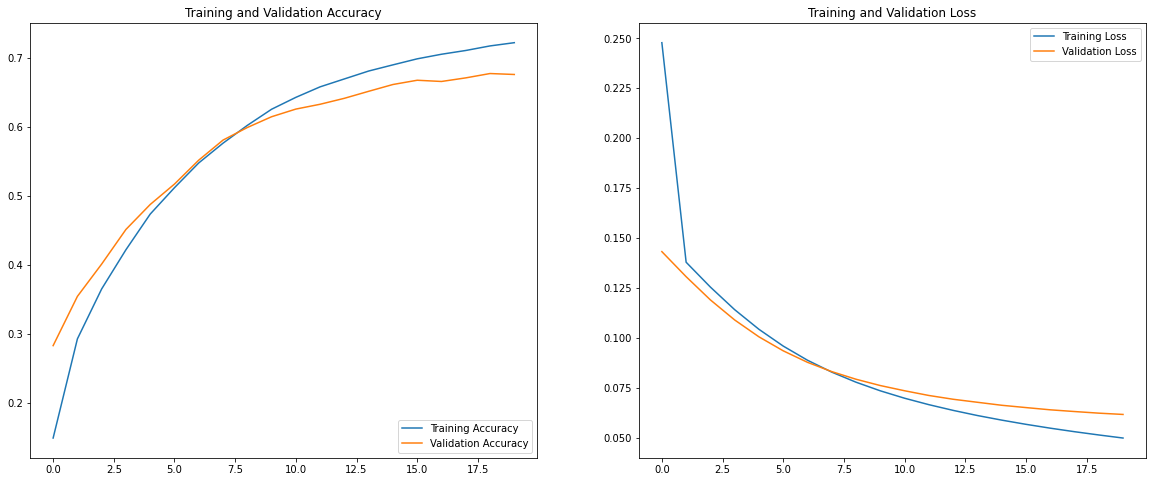

In [ ]:
plot_model_history(w2v_embed_model)

In [ ]:
w2v_embed_model.evaluate(test_padded, test_label_bin)

47/47 [==============================] - 0s 3ms/step - loss: 0.0624 - accuracy: 0.6725


[0.06241455301642418, 0.6724599003791809]

## Inférence sur le test set

In [ ]:
w2v_label_proba = w2v_embed_model.predict(test_padded)

47/47 [==============================] - 0s 2ms/step


In [ ]:
# Binarisation de la matrice des probabilités (Precision vs Recall Trade-off)
tresh = 0.3
w2v_label_proba[w2v_label_proba >= tresh] = 1
w2v_label_proba[w2v_label_proba < tresh] = 0

# Inverse transform
w2v_label_tags  = mlb.inverse_transform(w2v_label_proba)
test_label_tags = mlb.inverse_transform(test_label_bin)

pos = randint(0,test_label_bin.shape[0])
# display(test_df[body].iloc[pos])
# print()
print('predicted label :=', w2v_label_tags[pos])
print('actual label :=',test_label_tags[pos])

predicted label := ('linux',)
actual label := ('linux',)


## Évaluation des suggestions

In [ ]:
# Moyennisation des métriques utilisées
avg_index = ['samples avg', 'weighted avg','macro avg', 'micro avg' ]

In [ ]:
w2v_report = pd.DataFrame(classification_report(
    test_label_bin,
    w2v_label_proba,
    output_dict=True,
    target_names=mlb.classes_,
    zero_division=0
)).T

w2v_avg_report = w2v_report.loc[avg_index]
w2v_avg_report

,precision,recall,f1-score,support
samples avg,0.746324,0.650735,0.676159,1989.0
weighted avg,0.848365,0.586727,0.665083,1989.0
macro avg,0.829073,0.509522,0.603669,1989.0
micro avg,0.851825,0.586727,0.694850,1989.0


In [ ]:
w2v_clf_report = w2v_report[~w2v_report.index.isin(w2v_avg_report.index)]
w2v_clf_report.sort_values(by='f1-score', ascending=False)

,precision,recall,f1-score,support
git,0.944444,0.962264,0.953271,53.0
android,0.939759,0.838710,0.886364,93.0
python,0.903030,0.823204,0.861272,181.0
ruby-on-rails,1.000000,0.739130,0.850000,23.0
php,0.918033,0.788732,0.848485,71.0
java,0.877863,0.766667,0.818505,150.0
css,0.886364,0.750000,0.812500,52.0
django,1.000000,0.666667,0.800000,27.0
bash,1.000000,0.657143,0.793103,35.0
c++,0.870130,0.728261,0.792899,92.0


On peut voir qu'avec le modèle Word2Vec tout les tags ont été suggérés. Pour les labels les plus représentés, on a le scénario idéal avec les trois métriques étant supérieure à 0.8. Les performances globales sont nettement meilleures que précédemment avec des précisions élevées et des rappels plutôt moyens: le modèle prédit gloablement peu (certaines suggestions sont vides !) mais bien. 

unique tags :=  35


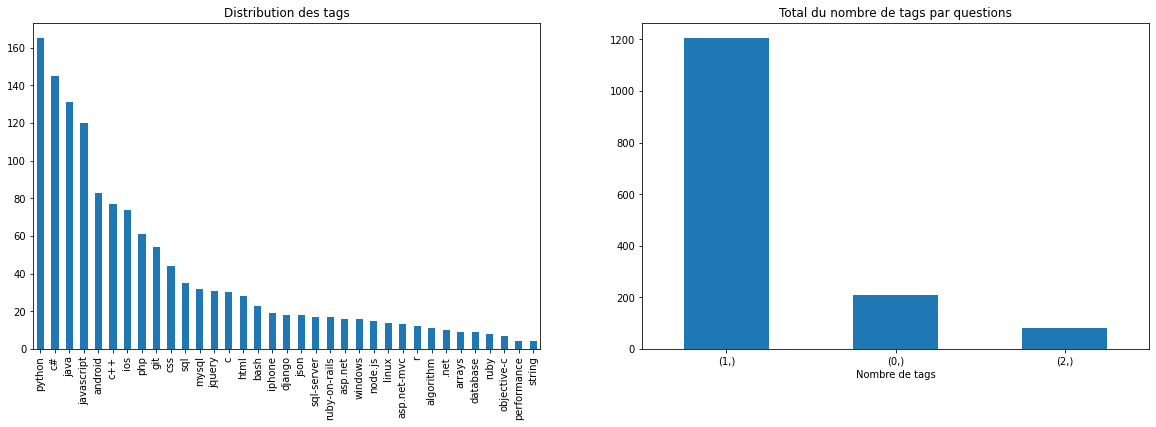

In [ ]:
# Comptage du nombre de tags suggérés dans les predictions w2v
w2v_label_count = [len(taggs) for taggs in w2v_label_tags]

plot_tag_list_count(w2v_label_tags, w2v_label_count)

# <font color="red" id=section_5> 5. Modélisation via Transfer Learning. </font>

Enfin, nous allons modéliser le système de suggestions de tags via deux modèles de transfer learning: [BERT](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4) et [USE](https://tfhub.dev/google/universal-sentence-encoder/4). 
Grâce à leur pré-entrainement sur de grands corpus de texte, ces modèles possèdent une "représentation" linguistique du vocabulaire qui leurs sont propres. Il est ensuite possible de les customiser pour une tâche particulière (donc de le ré-entraîner sur un corpus en particulier).

Ici, il n'est pas utile de vectoriser les documents en amont car ces deux modèles peuvent prendre en input le texte brut. Les deux modèles possèdent leurs propres algorithmes d'encodages de séquences. 
Nous allons utiliser le second corpus `Body_pc` qui est l'équivalent contextualisé de `Body_lm`. Comme précédemment, la sortie des modèles sera fournit directement à un classifieur softmax qui fournira les probabilités de pertinences pour chaque tags.

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

Ici, nous utilisons la colonne `Body_pc` qui contient les ponctuations.

In [ ]:
# Chargement des jeux de données train & test
Body = 'Body_pc'

mlb = MultiLabelBinarizer()

tl_train_feats, tl_test_feats, train_label_bin, test_label_bin, mlb = load_train_test_corpus('train_df_tronc.csv',
                                                                                       'test_df_tronc.csv', 
                                                                                       Body, 
                                                                                       mlb,
                                                                                       apply=False)

Load train_df_tronc.csv
Load test_df_tronc.csv

Features:
Shape of x train: (36465,)
Shape of x test: (1496,)

Target Binarization:


100%|██████████| 1496/1496 [00:00<00:00, 108022.08it/s]

Shape of y train: (36465, 35)
Shape of y test: (1496, 35)


In [ ]:
# Moyennisation des métriques utilisées
avg_index = ['samples avg', 'weighted avg','macro avg', 'micro avg' ]

# <font color="red" id=section_5_1> 5.1 Suggestion avec le modèle BERT. </font>

`BERT` (Bidirectional Encoder Representations from Transformers) est un modèle de Deep Learning développé par Google en [2018](https://fr.wikipedia.org/wiki/BERT_(mod%C3%A8le_de_langage)).
Son architecture *Transformers*, formé de 12 (ou 24) couches d'encodeurs empilés, prend en entrée la séquence entière de mots en une seule fois contrairement au réseaux de neurones récurrents parcourant la séquence d'entrée mots par mots (de manière unidirectionnelle). Chaque encodeur se compose de deux sous-couches : une couche d'auto-attention suivie d'un réseau de neurones complètement connecté. Cette caractéristique permet au modèle d'apprendre le contexte d'un mot à partir de la séquence entière.

<!-- Since BERT’s goal is to generate a language model, only the encoder mechanism is necessary.  -->

À la sortie de la dernière couche d'encodeur, le modèle fournit trois type de sortie pour une séquence:
 1. `pooled_output` : Un embedding pour la sequence entière (de dimension (batch_size, 768)).
 2. `sequence_output` : Un embedding pour chaque token de la sequence (de dimension (batch_size, max_seqlen=128, 768)).
 3. `encoder_output` : Est une liste python qui retourne l'embedding précedent à la sortie de chacunes des couches intermédiaires d'encodeurs.

In [ ]:
# del use_embed, use_embed_model, use_history

In [ ]:
# Couche de preprocessing
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", 
                                 name="BERT_preprocessing_layer")
# Couche d'encodage
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", 
                              trainable=True, 
                              name="BERT_encoding_layer")

In [ ]:
text_input        = tf.keras.layers.Input(shape=(), 
                                          dtype=tf.string, 
                                          name= "Input_layer")
preprocessed_text = bert_preprocess(text_input)
encoded_text      = bert_encoder(preprocessed_text)

b = encoded_text['pooled_output']
b = tf.keras.layers.Dense(nbr_tags, 
                          activation='softmax', 
                          name="Last_layer")(b)

bert_embed_model = tf.keras.Model(inputs=[text_input], outputs = b)

bert_embed_model.compile(optimizer=tf.keras.optimizers.Adam(2e-6), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])

bert_embed_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_layer (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 BERT_preprocessing_layer (Kera  {'input_type_ids':   0          ['Input_layer[0][0]']            
 sLayer)                        (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
bert_embed_model.fit(
    tl_train_feats, 
    train_label_bin,
    validation_split=0.2,
    batch_size=32,
    epochs=15,
)

Epoch 1/15
912/912 [==============================] - 889s 957ms/step - loss: 0.2334 - accuracy: 0.0982 - val_loss: 0.1515 - val_accuracy: 0.1728
Epoch 2/15
912/912 [==============================] - 872s 956ms/step - loss: 0.1390 - accuracy: 0.3127 - val_loss: 0.1178 - val_accuracy: 0.4739
Epoch 3/15
912/912 [==============================] - 871s 955ms/step - loss: 0.1087 - accuracy: 0.5013 - val_loss: 0.0938 - val_accuracy: 0.5559
Epoch 4/15
912/912 [==============================] - 870s 954ms/step - loss: 0.0895 - accuracy: 0.5754 - val_loss: 0.0803 - val_accuracy: 0.6041
Epoch 5/15
912/912 [==============================] - 870s 954ms/step - loss: 0.0774 - accuracy: 0.6224 - val_loss: 0.0712 - val_accuracy: 0.6416
Epoch 6/15
912/912 [==============================] - 869s 953ms/step - loss: 0.0691 - accuracy: 0.6512 - val_loss: 0.0654 - val_accuracy: 0.6546
Epoch 7/15
912/912 [==============================] - 870s 954ms/step - loss: 0.0631 - accuracy: 0.6668 - val_loss: 0.0611 -

## Évaluation du modèle 

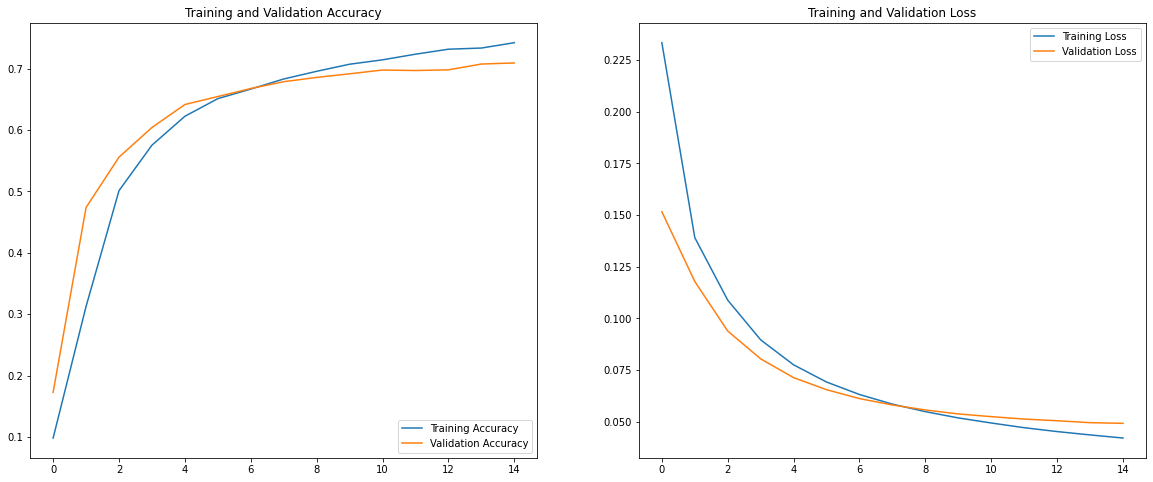

In [ ]:
plot_model_history(bert_embed_model)

In [ ]:
bert_embed_model.evaluate(tl_test_feats, test_label_bin)

47/47 [==============================] - 16s 332ms/step - loss: 0.0508 - accuracy: 0.6952


[0.050819892436265945, 0.6951871514320374]

## Inférence sur le test set

In [ ]:
bert_label_proba = bert_embed_model.predict(tl_test_feats)

47/47 [==============================] - 17s 345ms/step


In [ ]:
tresh = 0.3
bert_label_proba[bert_label_proba >= tresh] = 1
bert_label_proba[bert_label_proba < tresh] = 0

# Inverse transform
bert_label_tags = mlb.inverse_transform(bert_label_proba)
test_label_tags = mlb.inverse_transform(test_label_bin)

pos = randint(0,bert_label_proba.shape[0])
display(test_df_short.iloc[pos])
print()
print('predicted label :=', bert_label_tags[pos])
print('actual label :=', test_label_tags[pos])

Best_Tags                                                                                                                                                                       [c++, linux]
Body_pc      linux c++ error undefined reference to dlopen . i work in linux with c++ eclipse  and want to use a library. eclipse shows me an error do you know a solution? here is my code 
Body_lm                                                                                                 linux c++ undefined reference dlopen linux c++ eclipse library eclipse show solution
Name: 956640, dtype: object


predicted label := ('c++', 'linux')
actual label := ('c++', 'linux')


## Évaluation des suggestions

In [ ]:
bert_report = pd.DataFrame(classification_report(
    test_label_bin,
    bert_label_proba,
    output_dict=True,
    target_names=mlb.classes_,
    zero_division=0
)).T

bert_avg_report = bert_report.loc[avg_index]
bert_avg_report

,precision,recall,f1-score,support
samples avg,0.826872,0.726159,0.752807,1958.0
weighted avg,0.812330,0.659857,0.720162,1958.0
macro avg,0.778741,0.598250,0.668775,1958.0
micro avg,0.822930,0.659857,0.732426,1958.0


In [ ]:
bert_clf_report = bert_report[~bert_report.index.isin(bert_avg_report.index)]
bert_clf_report.sort_values(by='support', ascending=False)

,precision,recall,f1-score,support
python,0.939394,0.856354,0.895954,181.0
javascript,0.927419,0.696970,0.795848,165.0
java,0.870748,0.785276,0.825806,163.0
c#,0.654676,0.664234,0.659420,137.0
android,0.869565,0.847458,0.858369,118.0
html,0.720930,0.378049,0.496000,82.0
c++,0.727273,0.800000,0.761905,80.0
.net,0.622222,0.368421,0.462810,76.0
ios,0.776316,0.819444,0.797297,72.0
php,0.921569,0.746032,0.824561,63.0


Les performances globales sont légèrement supérieures au modèle Word2Vec. Ces deux modèles de Deep Learning montrent un même comportement: Une précision élevée et un rappel généralement supérieur à 0.5. Les tags ayant été prédit avec le meilleur *f1-score* sont PAREIL que pour Word2Vec. Seul le label `performance` n'a pas été suggéré.

unique tags :=  34


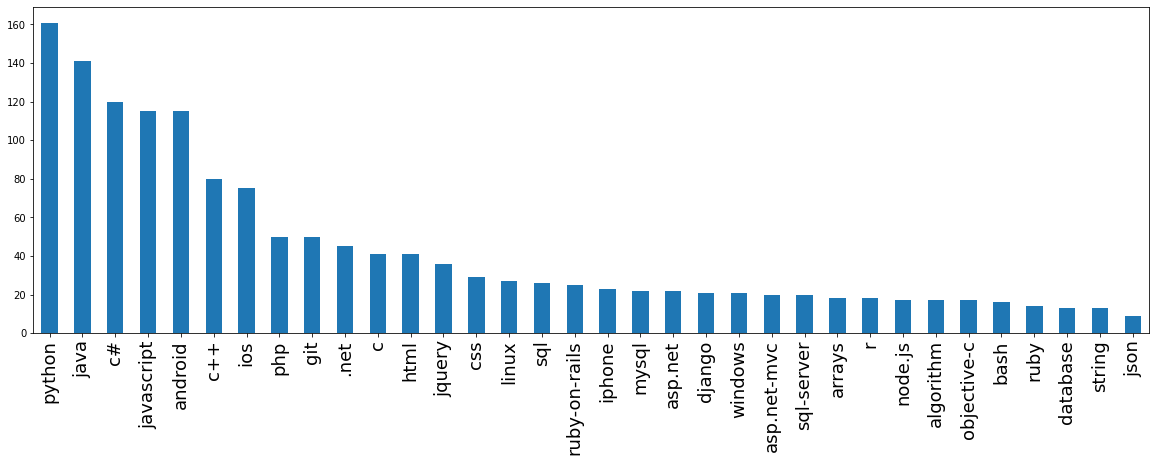

In [ ]:
# Comptage du nombre de tags suggérés dans les prediction lda et le test set
bert_label_count = [len(taggs) for taggs in bert_label_tags]

plot_tag_list_count(bert_label_tags, bert_label_count)

# <font color="red" id=section_5_2> 5.2 Suggestion avec le modèle USE. </font>

`USE` (pour `Universal Sentence Encoder`) est un modèle pré-entraîné de *sentence embeddings* particulièrement adapté pour résoudre des problèmes d'analyse de similarité sémantique de phrases ou de paragraphes, ainsi que pour la classification.

L'architecture du modèle que nous utilisons ici est construite avec un encodeur *Deep Averaging Network*, consistant à calculer un embedding pour la sequence entière en moyennant l'embedding de chacun des tokens de la séquence. Une variante basé sur l'architecture Transformers existe également.

En sortie, le modèle fournit un vecteur d'embedding de dimension 512 par séquences.

In [ ]:
# del use_embed_model, module_url, # use_history

In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'

use_embed = hub.KerasLayer(module_url, 
                           trainable=True, 
                           name="USE_layer")

In [ ]:
def build_model():
    
    model = keras.Sequential([
        keras.Input(
            shape=[], 
            dtype=tf.string, 
            name="Input_layer"
        ),
        use_embed,
        # keras.layers.Dropout(0.5),
        keras.layers.Dense(
            nbr_tags, 
            activation='softmax', 
            name="Last_layer"
        )
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-4),
        loss=tf.keras.losses.BinaryCrossentropy(), 
        metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')]
    )
    return model

use_embed_model = build_model()
use_embed_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_layer (KerasLayer)      (None, 512)               147354880 
                                                                 
 Last_layer (Dense)          (None, 35)                17955     
                                                                 
Total params: 147,372,835
Trainable params: 147,372,835
Non-trainable params: 0
_________________________________________________________________


In [ ]:
use_h = use_embed_model.fit(
    np.array(tl_train_feats), 
    train_label_bin,
    validation_split=0.2,
    batch_size=256,
    epochs=15,
)

Epoch 1/15


114/114 [==============================] - 203s 1s/step - loss: 0.4176 - accuracy: 0.0962 - val_loss: 0.2788 - val_accuracy: 0.1023
Epoch 2/15
114/114 [==============================] - 137s 1s/step - loss: 0.2261 - accuracy: 0.2576 - val_loss: 0.1902 - val_accuracy: 0.4083
Epoch 3/15
114/114 [==============================] - 141s 1s/step - loss: 0.1739 - accuracy: 0.4185 - val_loss: 0.1607 - val_accuracy: 0.4338
Epoch 4/15
114/114 [==============================] - 140s 1s/step - loss: 0.1529 - accuracy: 0.4451 - val_loss: 0.1454 - val_accuracy: 0.4555
Epoch 5/15
114/114 [==============================] - 140s 1s/step - loss: 0.1397 - accuracy: 0.4948 - val_loss: 0.1343 - val_accuracy: 0.5079
Epoch 6/15
114/114 [==============================] - 140s 1s/step - loss: 0.1286 - accuracy: 0.5764 - val_loss: 0.1247 - val_accuracy: 0.5830
Epoch 7/15
114/114 [==============================] - 140s 1s/step - loss: 0.1183 - accuracy: 0.6277 - val_loss: 0.1162 - val_accuracy: 0.6213
Epoch 8/15

## Évaluation du modèle 

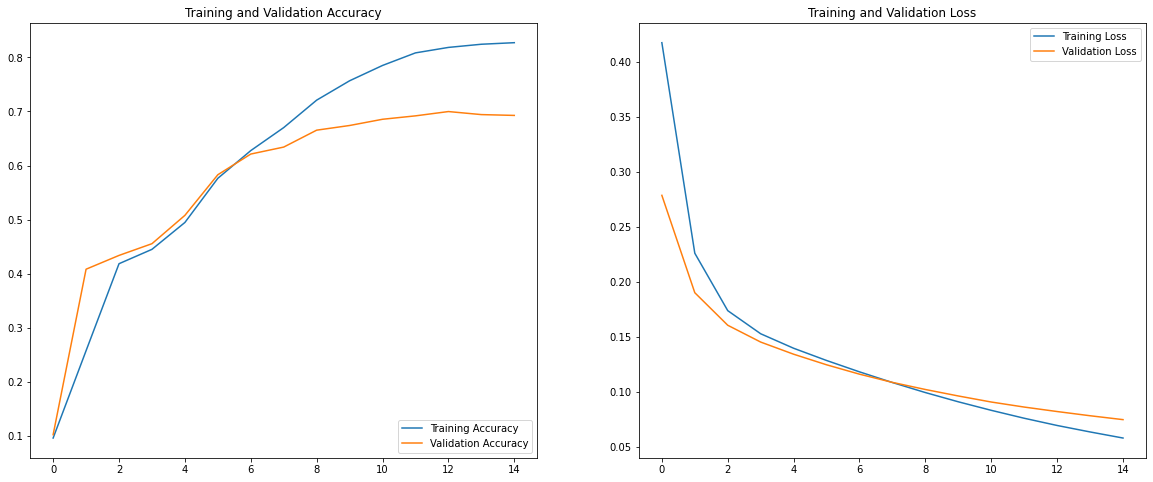

In [ ]:
plot_model_history(use_embed_model)

In [ ]:
use_embed_model.evaluate(np.array(tl_test_feats), test_label_bin)

47/47 [==============================] - 4s 75ms/step - loss: 0.0767 - accuracy: 0.6838


[0.0767490491271019, 0.6838235259056091]

## Inférence sur le test set

In [ ]:
use_label_proba = use_embed_model.predict(np.array(tl_test_feats))

47/47 [==============================] - 9s 75ms/step


In [ ]:
tresh = 0.3
use_label_proba[use_label_proba >= tresh] = 1
use_label_proba[use_label_proba < tresh] = 0

# Inverse transform
use_label_tags  = mlb.inverse_transform(use_label_proba)
test_label_tags = mlb.inverse_transform(test_label_bin)

pos = randint(0,use_label_proba.shape[0])
# display(test_df_short.iloc[pos])
print()
print('predicted label :=', use_label_tags[pos])
print('actual label :=',test_label_tags[pos])


predicted label := ()
actual label := ('r',)


## Évaluation des suggestions

In [ ]:
use_report = pd.DataFrame(classification_report(
    test_label_bin,
    use_label_proba,
    output_dict=True,
    target_names=mlb.classes_,
    zero_division=0
)).T

use_avg_report = use_report.loc[avg_index]
use_avg_report

,precision,recall,f1-score,support
samples avg,0.660762,0.567513,0.595633,1989.0
weighted avg,0.654995,0.505782,0.540897,1989.0
macro avg,0.427411,0.291767,0.322249,1989.0
micro avg,0.853265,0.505782,0.635101,1989.0


In [ ]:
use_clf_report = use_report[~use_report.index.isin(use_avg_report.index)]
use_clf_report.sort_values(by='f1-score', ascending=False)

,precision,recall,f1-score,support
git,0.963636,1.000000,0.981481,53.0
android,0.954545,0.903226,0.928177,93.0
python,0.899441,0.889503,0.894444,181.0
java,0.904412,0.820000,0.860140,150.0
php,0.867647,0.830986,0.848921,71.0
c++,0.822917,0.858696,0.840426,92.0
javascript,0.839161,0.784314,0.810811,153.0
ios,0.752941,0.790123,0.771084,81.0
c#,0.711538,0.735099,0.723127,151.0
css,0.882353,0.576923,0.697674,52.0


Bien que nous avons utilisé un *trade-off* precision/rappel relativement petit (`tresh = 0.3`), on voit que le modèle `USE` est le moins performant des modèles Deep Learning employés. De plus, la majorité des classes sous-représentées non pas été prédites. Le *f1-score* des meilleures suggestions restent cependant du même ordre de grandeur que précédemment.
Concernant la tendance précision/rappel, ici c'est l'inverse : High Precision/Low-recall A FINIR

unique tags :=  17


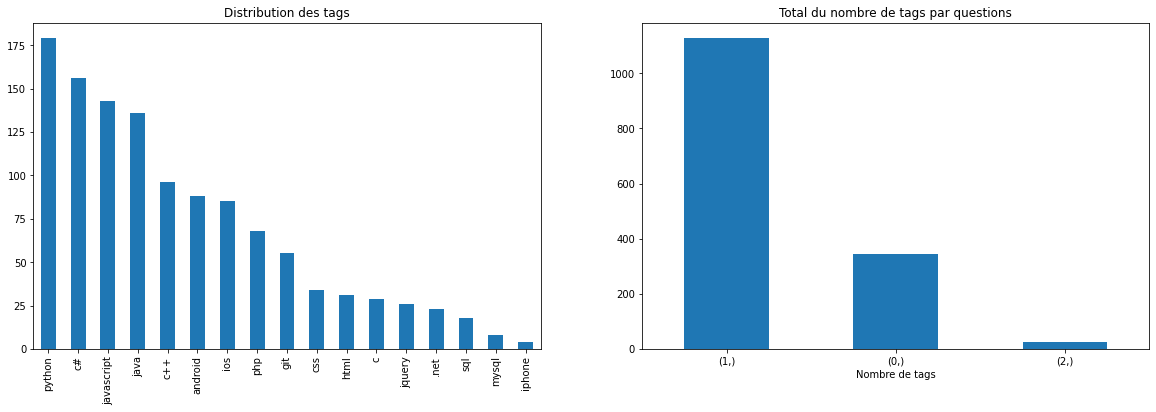

In [ ]:
# Comptage du nombre de tags suggérés dans les prediction lda et le test set
use_label_count = [len(taggs) for taggs in use_label_tags]

plot_tag_list_count(use_label_tags, use_label_count)

# En conclusion

Pour ce projet de suggestion de tags, on a vu qu'un simple modèle WordVec peut être aussi performant que les modèles pré-entraînés de l'état de l'art.